<a href="https://colab.research.google.com/github/ibader85/PredictiveAnalytics/blob/main/17_Classification_Trees_Using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

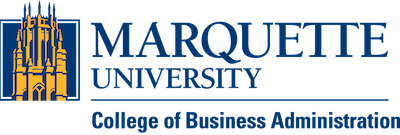

# BUAN 3065: Unlocking Business Insights with Predictive Analytics
# Classification Trees Using Python

Instructor: Dr. Badar Al Lawati

Hayden Sellar, the bank
manager of Sunnyville Bank, wants to use historical data from 500
bank customers to develop a classification model for determining
whether or not new bank customers will respond to a HELOC offer.


He also thinks that Sunnyville Bank is not targeting the right
customers when marketing its HELOC products and hopes that the
classification model will offer actionable insights for his company.


Hayden plans to assess the performance of the model and then classify
20 new bank customers as likely or unlikely to respond to a HELOC
offer

Most data mining algorithms including decision trees are available
in the Scikit-Learn package in Python

The algorithm for decision
trees supports the k-fold cross-validation method, which is less
sensitive to how the data is split compared to the holdout method.

Therefore, we partition the dataset into two parts: the training set
is used to create one or more models, and the validation set
(referred to as the test set to be consistent with the term used in
Python packages) is employed to assess model performance in
novel data.

In this particular case, we split the data in the
HELOC_Data worksheet into two segments: 70% for training and
30% for test, and then apply the 10-fold cross-validation technique
to identify the tree with optimal complexity.

In [1]:
# Import the excel file into Colab

import pandas as pd
myData = pd.read_excel('/content/HELOC.xlsx', sheet_name = 'HELOC_Data')
myData.head()

,Age,Sex,Income,HELOC
0,30,Female,101000,0
1,25,Male,86000,0
2,20,Male,50000,0
3,26,Male,58000,0
4,18,Female,93000,0


Our review of the data shows that one of the predictor variables,
Sex, is categorical.

Because Scikit-Learn’s decision tree
algorithm is not designed to work with categorical data, we use
the Pandas get_dummies function to convert Sex into a dummy
variable and drop the first category level, in this case, Female, to
avoid multicollinearity.


Before performing dummy coding, we use the str.strip function
to remove leading and trailing whitespace from the Sex column
to ensure that there are no unwanted spaces around the values.


This is important because having leading or trailing spaces in
the value can cause unexpected issues or errors when you create
dummy variables.

Therefore, it is a good practice to clean the
data before encoding categorical data.

The resulting dummy
variable, Male, would have two possible values, 0 (female) and 1
(male).

We then use the Pandas concat function to concatenate
myData and the new dummy variable. Finally, we remove the
original Sex column from the data frame as it is no longer
needed

In [2]:
myData.Sex = myData.Sex.str.strip()
myData = pd.concat([myData, pd.get_dummies(myData.Sex,
drop_first = True)], axis = 1)
myData = myData.drop('Sex', axis = 1)

We partition the data into 70% training and 30% test sets using
Scikit-Learn’s train_test_split function.

Within the training and
test sets, data are further partitioned into predictor variables
(i.e., X_train and X_test) and target variables (i.e., y_train and
y_test).

X_train and X_test include all the columns in myData
except the target variable, HELOC; to accomplish this, in the
first option of the train_test_split function, we use the drop
function with axis = 1, specifying that a column is removed from
the dataset.

The second option specifies the target variable,
myData.HELOC, that will be stored in y_train and y_test. We
use the option, test_size = 0.30, to specify the percentage of data
reserved for the test set.

Finally, the random_state option is used
to ensure reproducibility of the random partitioning.

By setting
the random_state to a fixed value such as 321, we ensure that the
data split remains the same every time the code is executed.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(myData.drop('HELOC', axis = 1),
myData.HELOC, test_size = 0.30, random_state = 321)

In [4]:
len(X_train)

350

In [5]:
len(X_test)

150

Now we import the DecisionTreeClassifier class and create a
variable of the classifier named CT_model.

We set the random
seed for the random number generator used by the decision tree
algorithm to 321 to ensure that the results are reproducible

In [6]:
from sklearn.tree import DecisionTreeClassifier
CT_model = DecisionTreeClassifier(random_state = 321)

We use the fit function to fit (train) the decision tree classifier
CT_model on the training data to generate a default
classification tree named default_tree.

In [7]:
default_tree = CT_model.fit(X_train, y_train)

We plot the default classification tree using the plot_tree
function

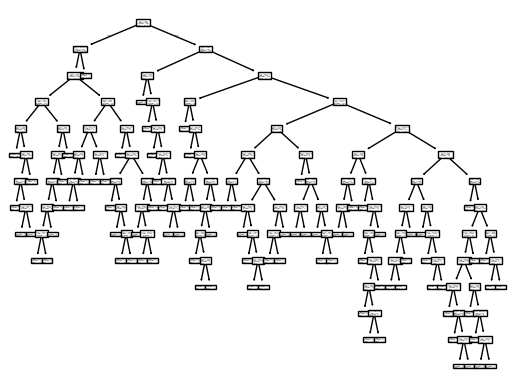

In [8]:
from sklearn import tree
tree.plot_tree(default_tree);

The resulting tree (shown above) is very complex and
impossible to read, and this is because the default tree produced
in Python is a full tree, which represents the maximum number
of splits.

As discussed earlier, a full tree tends to overfit the data,
resulting in low predictive performance when applied to new
cases.

Therefore, instead of trying to interpret the default tree,
we focus on identifying a tree with the optimal complexity in the
next step.

To identify a tree with optimal complexity, we use the
hyperparameter tuning technique with 10-fold cross-validation as
we did in the KNN and naïve Bayes examples.

In Python, it is a
common practice to include cost complexity parameter
(ccp_alpha) along with other hyperparameters when tuning your
model. By searching over a range of values for these
hyperparameters, you can find the combination that results in
the best-performing pruned tree.

In this example, we include
maximum depth (max_depth) and minimum samples of leaf
nodes (min_samples_leaf) as the two additional
hyperparameters.

Maximum depth controls how deep the
pruned tree can be, and minimum samples leaf specifies the
minimum number of samples required to be in a leaf node,
influencing the tree’s granularity.

To define a grid of
hyperparameter values, we create a dictionary variable,
paramGrid, to store the three hyperparameters and their ranges.

The range for the ccp_alpha value is set by using
CT_model.cost_complexity_pruning_path(X_train,
y_train).ccp_alphas, which generates a range of potential
complexity cost values computed from the training data.

The
ranges for max_depth and min_samples_leaf are set to values
from 1 to 10.

In [9]:
paramGrid = {'ccp_alpha':
CT_model.cost_complexity_pruning_path(X_train,
y_train).ccp_alphas, 'max_depth': range(1, 10 + 1),
'min_samples_leaf': range(1, 10 + 1)}

We then import the Scikit-Learn’s GridSearchCV class and
create a variable of the class named search with five options.

The first two options are used to specify our model and the grid
of hyperparameter values (paramGrid). The cv = 10 option
specifies that we will use the 10-fold cross-validation method.

The scoring = “accuracy” option chooses accuracy as the scoring
metric for comparing candidate classification tree models.

The
last option, n_jobs = −1, means that all available CPU cores will
be used for running the models in parallel to speed up the grid
search process.

We include this option because we anticipate the
number of candidate models to be relatively large due to the
large number of combinations of the three hyperparameters.

In [10]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(CT_model, paramGrid, cv = 10,
scoring = 'accuracy', n_jobs = -1)

We use the fit function to train the classification tree model,
search, using the training data set and save the result in
pruned_tree.

Because a relatively large number of
hyperparameter combinations are evaluated, the processing
would take anywhere from a few seconds to few minutes
depending on the processing capacity of your computer.

We
then view the results in a data frame using the cv_results_
attribute of pruned_tree.

In [11]:
pruned_tree = search.fit(X_train, y_train)
pd.DataFrame(pruned_tree.cv_results_)

# 3,200 candidate trees with different hyperparameter combinations were evaluated

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011770,0.004652,0.007318,0.003094,0.000000,1,1,"{'ccp_alpha': 0.0, 'max_depth': 1, 'min_sample...",0.714286,0.742857,...,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.74,0.008571,2745
1,0.010585,0.001553,0.006552,0.001039,0.000000,1,2,"{'ccp_alpha': 0.0, 'max_depth': 1, 'min_sample...",0.714286,0.742857,...,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.74,0.008571,2745
2,0.009959,0.002816,0.007579,0.002999,0.000000,1,3,"{'ccp_alpha': 0.0, 'max_depth': 1, 'min_sample...",0.714286,0.742857,...,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.74,0.008571,2745
3,0.010904,0.002152,0.007009,0.000802,0.000000,1,4,"{'ccp_alpha': 0.0, 'max_depth': 1, 'min_sample...",0.714286,0.742857,...,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.74,0.008571,2745
4,0.010236,0.001931,0.007488,0.000672,0.000000,1,5,"{'ccp_alpha': 0.0, 'max_depth': 1, 'min_sample...",0.714286,0.742857,...,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.74,0.008571,2745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,0.005433,0.000841,0.003238,0.000130,0.079115,10,6,"{'ccp_alpha': 0.07911459712206526, 'max_depth'...",0.714286,0.742857,...,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.74,0.008571,2745
3196,0.004859,0.000188,0.003177,0.000175,0.079115,10,7,"{'ccp_alpha': 0.07911459712206526, 'max_depth'...",0.714286,0.742857,...,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.74,0.008571,2745
3197,0.005203,0.000389,0.003306,0.000250,0.079115,10,8,"{'ccp_alpha': 0.07911459712206526, 'max_depth'...",0.714286,0.742857,...,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.74,0.008571,2745
3198,0.005340,0.000837,0.003156,0.000233,0.079115,10,9,"{'ccp_alpha': 0.07911459712206526, 'max_depth'...",0.714286,0.742857,...,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.742857,0.74,0.008571,2745


The resulting table is too large to display on this page.

To make
the results clearer, we sort the output based on accuracy ranking
(stored in the rank_test_score column) using the sort_values
function and only display the most relevant results.

In addition,
we only display the results for the first 20 trees in the list

In [12]:
pd.DataFrame(pruned_tree.cv_results_).sort_values('rank_test_score')[['param_ccp_alpha', 'param_max_depth', 'param_min_samples_leaf', 'mean_test_score', 'rank_test_score']].head(20)

,param_ccp_alpha,param_max_depth,param_min_samples_leaf,mean_test_score,rank_test_score
2648,0.006390,5,9,0.794286,1
2649,0.006390,5,10,0.794286,1
2658,0.006390,6,9,0.794286,1
2688,0.006390,9,9,0.794286,1
2678,0.006390,8,9,0.794286,1
2669,0.006390,7,10,0.794286,1
2668,0.006390,7,9,0.794286,1
2659,0.006390,6,10,0.794286,1
2689,0.006390,9,10,0.794286,1
2679,0.006390,8,10,0.794286,1


As you can see, the first 12 trees all
have the same accuracy, hence they are all ranked number 1.
The algorithm will choose the simplest tree among them as the
pruned_tree.

In this case, tree number 2648 with ccp_alpha =
0.0064, max_dep = 5, and min_samples_leaf = 9 is selected as
the best estimator.

We can verify this using the best_estimator_
attribute

In [13]:
pruned_tree.best_estimator_

DecisionTreeClassifier(ccp_alpha=np.float64(0.006389601609002492), max_depth=5,
                       min_samples_leaf=9, random_state=321)

In [14]:
# To find out the total number of nodes in the best pruned tree, we access the tree_.node_count attribute

pruned_tree.best_estimator_.tree_.node_count

11

To find
out the number of leaf nodes in the best pruned tree, we access
the tree_.feature attribute, which provides an array that stores
the features that are used for splitting at each node in the tree.

For leaf nodes, the feature array contains the value −2,
indicating that the node is a leaf node and does not perform any
further splitting.

By counting the number of “−2”s in the array,
we find the number of leaf nodes of the best pruned tree.

In [15]:
feature_array = pruned_tree.best_estimator_.tree_.feature
import numpy as np
np.count_nonzero(feature_array == -2)

6

[Text(0.25, 0.9166666666666666, 'Male <= 0.5\ngini = 0.385\nsamples = 350\nvalue = [259, 91]\nclass = 0'),
 Text(0.125, 0.75, 'gini = 0.145\nsamples = 191\nvalue = [176, 15]\nclass = 0'),
 Text(0.1875, 0.8333333333333333, 'True  '),
 Text(0.375, 0.75, 'Age <= 25.5\ngini = 0.499\nsamples = 159\nvalue = [83, 76]\nclass = 0'),
 Text(0.3125, 0.8333333333333333, '  False'),
 Text(0.25, 0.5833333333333334, 'gini = 0.175\nsamples = 31\nvalue = [28, 3]\nclass = 0'),
 Text(0.5, 0.5833333333333334, 'Income <= 24000.0\ngini = 0.49\nsamples = 128\nvalue = [55, 73]\nclass = 1'),
 Text(0.375, 0.4166666666666667, 'gini = 0.415\nsamples = 17\nvalue = [12, 5]\nclass = 0'),
 Text(0.625, 0.4166666666666667, 'Income <= 71500.0\ngini = 0.475\nsamples = 111\nvalue = [43, 68]\nclass = 1'),
 Text(0.5, 0.25, 'gini = 0.307\nsamples = 37\nvalue = [7, 30]\nclass = 1'),
 Text(0.75, 0.25, 'Income <= 134500.0\ngini = 0.5\nsamples = 74\nvalue = [36, 38]\nclass = 1'),
 Text(0.625, 0.08333333333333333, 'gini = 0.428\ns

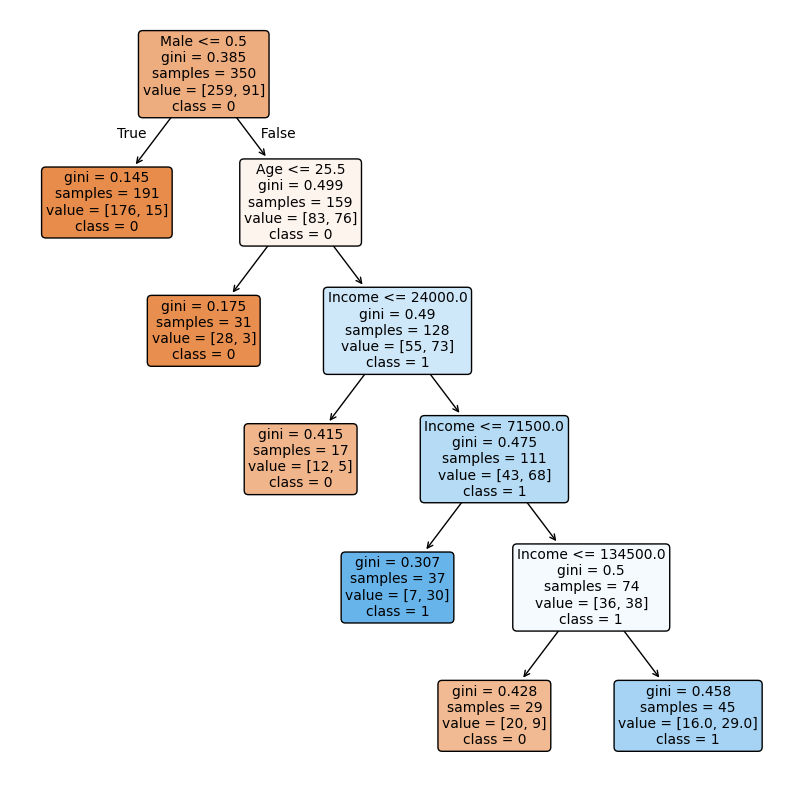

In [16]:
# Let's plot the pruned_tree

import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(10,10))
tree.plot_tree(pruned_tree.best_estimator_, feature_names = X_train.columns, class_names =
pruned_tree.classes_.astype('str'), filled = True, rounded = True, fontsize = 10)

To assess the performance of the classification tree model on an
unseen data set, we apply the pruned tree to the test data set.

The predicted class memberships are saved in a variable named
testPredictions.

In [17]:
testPredictions = pruned_tree.predict(X_test)

We then use Scikit-Learn’s confusion_matrix function to
compare the actual class memberships of the test data cases
(y_test) with the predicted class memberships (testPredictions)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, testPredictions)

array([[101,  10],
       [ 24,  15]])

Alternatively, we can visualize the confusion matrix
using Scikit-Learn’s ConfusionMatrixDisplay class and
Matplotlib’s pyplot module, which is designed for creating plots.


The first three options specify our classification tree model,
predictor variables of the test data, and target variable of the test
data.

The last option specifies that the blue colormap would be
used for color-coding the cells in the confusion matrix.

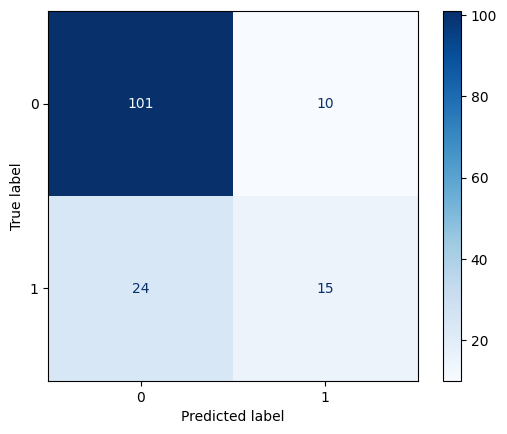

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_estimator(pruned_tree, X_test, y_test, cmap = plt.cm.Blues);

In [20]:
# To compute the overall accuracy rate, we use Scikit-Learn’s accuracy_score function

from sklearn.metrics import accuracy_score
accuracy_score(y_test, testPredictions)

# The overall accuracy rate of 0.7733

0.7733333333333333

To obtain the other common performance measures, we use
Scikit-Learn’s classification_report function and specify the label
for the target class (Class 1) to be “Will Respond” and the label
for the nontarget class (Class 0) to be “Will Not Respond”.

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, testPredictions,
target_names = ['Will Not Respond', 'Will Respond'], digits = 4))

                  precision    recall  f1-score   support

Will Not Respond     0.8080    0.9099    0.8559       111
    Will Respond     0.6000    0.3846    0.4688        39

        accuracy                         0.7733       150
       macro avg     0.7040    0.6473    0.6623       150
    weighted avg     0.7539    0.7733    0.7553       150



Note
that for a binary classification problem such as this one,
sensitivity is represented by recall for the target class and
specificity is represented by recall for the nontarget class.

Therefore, the sensitivity and specificity of our classification tree
model are 0.3846 and 0.9099, respectively.

When asked to
report precision, we usually only report the precision for the
target class, and in this case, 0.60.

To evaluate the predictive performance of the classification tree
model, we can compare its performance measures to those of
the naïve rule, where all cases are classified into the
predominant class.

Because there are 39 target class (Will
Respond) cases and 111 nontarget class (Will Not Respond)
cases among the 150 test data cases, the naïve rule would
classify all cases into the nontarget class and produce an
accuracy rate of 111 ÷ 150 = 0.74, sensitivity of 0, and specificity
of 1.

Therefore, the classification tree shows better predictive
performance than the naïve rule does, especially if the goal is to
identify target class cases.


However, the sensitivity and specificity values suggest that, while
the overall accuracy rate is relatively high, the model classifies a
much larger portion of the nontarget class (customers who do
not respond to HELOC offers) cases than target class
(customers who respond to HELOC offers) cases correctly
using the default cutoff rate of 0.5

The choice of the cutoff
value can influence the confusion matrix and the resulting
performance measures.

By default, Scikit-Learn uses 0.5 as the
cutoff value for binary choice models.

The analyst may choose
to increase or decrease the cutoff value to classify fewer or more
observations into the target class due to asymmetric
misclassification costs or uneven class distributions.
Sometimes
we use the proportion of target class cases in the data as the
cutoff value

In this example, the opportunity cost of missing a potential
customer who would respond is likely to be higher than the cost
of reaching out to a potential customer who ends up not
responding.

Furthermore, only 26% of the customers in the data
set responded to the HELOC offer suggesting that the
probability of a customer responding is about 0.26 instead of the
default probability of 0.5.

In this case, the manager may reduce
the cutoff value to a lower value than 0.5 in order to classify
more cases into the target class to achieve a higher sensitivity
value.

To evaluate the predictive performance of the classification tree
model using a different cutoff value, we first compute the
probability of each case belonging to the target classes instead of
its class membership.

The predict_proba function can be used
for this purpose.

The predicted probability values are saved in a
variable named testPredictionProbs.

We then take a look at the
probabilities for the first 10 cases.

In [22]:
testPredictionProbs = pruned_tree.predict_proba(X_test)
testPredictionProbs[:10,]

array([[0.92146597, 0.07853403],
       [0.35555556, 0.64444444],
       [0.35555556, 0.64444444],
       [0.70588235, 0.29411765],
       [0.92146597, 0.07853403],
       [0.68965517, 0.31034483],
       [0.92146597, 0.07853403],
       [0.92146597, 0.07853403],
       [0.70588235, 0.29411765],
       [0.68965517, 0.31034483]])

The first column in the output above shows
the probabilities of the cases belonging to Class 0 (Will Not
Respond), while the second column lists the probabilities of the
cases belonging to Class 1 (Will Respond).

To determine class
memberships using a cutoff value other than the default
probability of 0.5 (e.g., 0.26, in order to accurately classify more
Class 1 cases), we compare the values in the second column to
the new cutoff value.

We use the NumPy’s where function to test which values in the
second column are greater than the cutoff of 0.26; values that
are greater will be scored a 1 and values that are not will be
scored a 0.

The second column of the predicted probability data
frame is referenced via the slice [:, 1], which indicates all rows in
the second column.

Recall that in Python, since the first column
is indexed by a 0, the second column is represented by 1.

We
store the resulting class memberships in a new variable named
testPredsCustomCutoff.

We then construct a new confusion
matrix and compute other common performance measures.

In [23]:
import numpy as np
testPredsCustomCutoff = np.where(testPredictionProbs[:, 1] > 0.26, 1, 0)
confusion_matrix(y_test, testPredsCustomCutoff)
accuracy_score(y_test, testPredsCustomCutoff)
print(classification_report(y_test, testPredsCustomCutoff, target_names = ['Will Not Respond', 'Will Respond'], digits = 4))

                  precision    recall  f1-score   support

Will Not Respond     0.9263    0.7928    0.8544       111
    Will Respond     0.5818    0.8205    0.6809        39

        accuracy                         0.8000       150
       macro avg     0.7541    0.8067    0.7676       150
    weighted avg     0.8367    0.8000    0.8093       150



Both the overall accuracy and sensitivity have
increased, allowing the bank to classify more target class cases
correctly.

To create the cumulative lift chart, we create a dataframe
containing the actual class memberships (0 or 1) and the
predicted probabilities for the target/positive class (1).

The
dataframe is then sorted in descending order of predicted
probabilities, and we compute the cumulative gain metrics by
calculating the cumulative sum of the actual positives and
normalizing it by the total positives.

Additionally, we calculate the percentage of the population for plotting.

Finally, we plot the cumulative lift chart, comparing the model's performance with the baseline random performance.

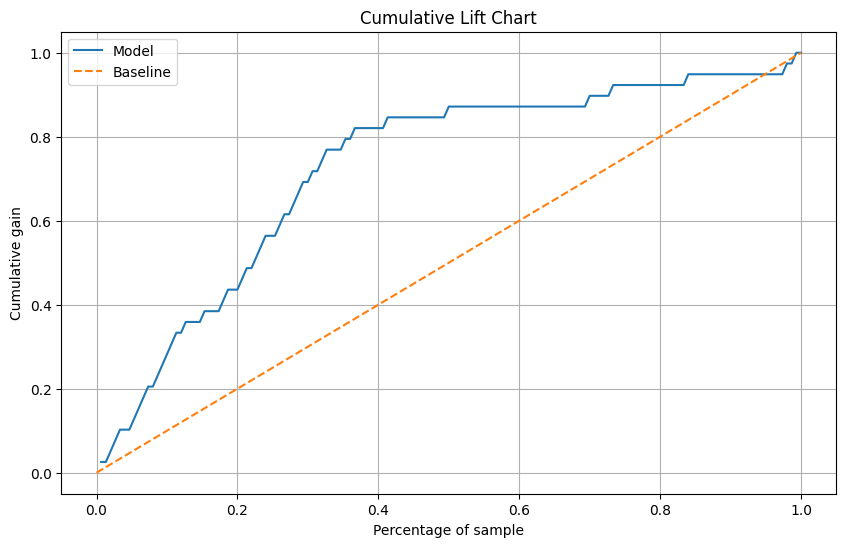

(Text(0.5, 1.0, 'Cumulative Lift Chart'),
 Text(0.5, 24.0, 'Percentage of sample'),
 Text(24.000000000000007, 0.5, 'Cumulative gain'),
 None,
 None)

In [24]:
testOutcomes = pd.DataFrame({'Actuals': y_test, 'Probs': testPredictionProbs[: ,1]})
data = testOutcomes. sort_values(by='Probs', ascending=False). reset_index(drop=True)
data['cumulative_positives'] = data['Actuals'].cumsum()
total_positives = data['Actuals']. sum()
data['cumulative_gain' ] = data['cumulative_positives'] / total_positives
data['percentage_population'] = (np. arange(1, len(data) + 1) / len(data))
plt. figure(figsize=(10, 6))
plt.plot(data['percentage_population'], data['cumulative_gain'], label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Baseline')
plt.title('Cumulative Lift Chart'), plt.xlabel ('Percentage of sample'), plt.ylabel ('Cumulative gain'), plt. legend(), plt.grid(), plt.show()

Although the un our ves for both classes are important, in our example, the manager of the bank would likely be more interested in the lift curve (also called gain curve) of the target class (Class 1).

The target class (Will Respond) from the classification tree model lies well above the diagonal line, indicating that the model performs considerably better than the baseline model in terms of predicting whether or not a customer will respond to a HELOC offer.

To create the decile-wise lift chart, we first need to compute a cumulative gains table.

In [25]:
testOutcomes = pd.DataFrame({'Actuals': y_test, 'Probs': testPredictionProbs[:, 1]})
cuts = pd.qcut (testOutcomes.Probs, q = 10, duplicates = 'drop')
lifts = (testOutcomes.groupby(cuts)['Actuals']. sum() / cuts.value_counts()) / np.mean(testOutcomes.Actuals)
plotDat = pd. DataFrame({'Lift': np.round(lifts, 3), 'N': cuts.value_counts()})
plotDat['Cumulative N'] = np.cumsum(np.flip(plotDat.N))
plotDat['Cumulative Percentile'] = round(plotDat['Cumulative N'] / len(testOutcomes) * 100, 0). astype('int')
plotDat

/tmp/ipython-input-3831925830.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lifts = (testOutcomes.groupby(cuts)['Actuals']. sum() / cuts.value_counts()) / np.mean(testOutcomes.Actuals)


,Lift,N,Cumulative N,Cumulative Percentile
Probs,,,,
"(0.0775, 0.0968]",0.283,95,150,100
"(0.0968, 0.299]",1.923,10,55,37
"(0.299, 0.31]",2.308,20,45,30
"(0.31, 0.644]",1.748,11,25,17
"(0.644, 0.811]",2.747,14,14,9


Only five groups were created in the cumulative gains table due to lack of variability in the predicted probability values. As expected, the groups with higher probabilities all have higher lift values.

For example, in the group with the highest probabilities, the lift value is 2.747, suggesting that the top 9% of the test data cases with the highest predicted probabilities of belonging to the target class (Will Respond) capture 2.747 times as many actual target class cases, compared to randomly selecting 9% of the test data cases.

Higher lift values for the first few groups with the highest predicted probabilities are indicative of the effectiveness of the model.

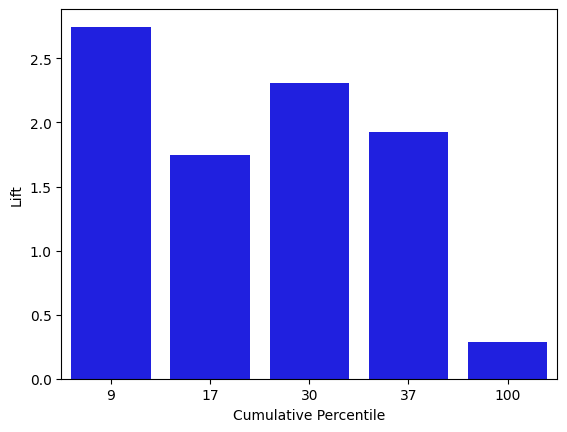

In [26]:
# Let's create the decile-wise lift chart to visualize the information from the cumulative gains
# table using Seaborn's barplot runvuon

import seaborn as sns
sns.barplot(y = 'Lift', x = 'Cumulative Percentile', data = plotDat, color = 'blue');

To create a receiver operating characteristic (ROC) curve for the model, we first import the Scikit-Learn's RocCurveDisplay class.

We then create a new 8-inches-by-8-inches figure and axis for plotting using Matplotlib. We also plot a diagonal dashed line in black on the plot.

This line represents the ROC curve of a random classifier, which has an area under the curve (AUC) value of 0.5.

It serves as a reference line to compare the performance of the classification tree model.

Using Scikit-Learn's RocCurveDisplay.from_estimator function, we generate the ROC curve and plot it in the Matplotlib axis created earlier.

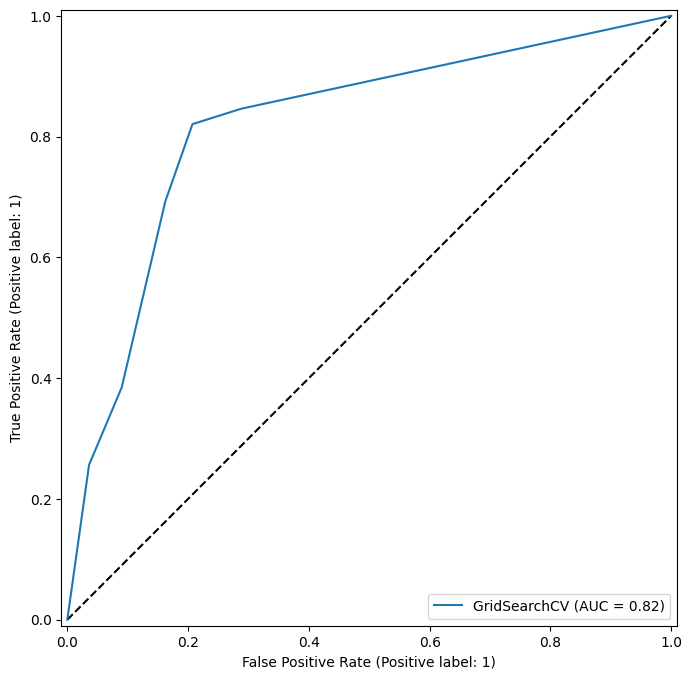

In [28]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls ='--', c = 'k')
RocCurveDisplay.from_estimator(pruned_tree, X = X_test, y = y_test, ax = ax);

In [29]:
# Alternatively, we can use the Scikit-Learn's roc_auc_score function with the actual class
# memberships (y_test) and the predicted probabilities of belonging to the target class
#(testPredictionProbs) to compute the AUC value.

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, testPredictionProbs[:, 1])

np.float64(0.8193578193578194)

Let's fit the model to the novel data in the HELOC_Score worksheet.

We first import the data from the HELOC_Score worksheet of the HELOC data file into a DataFrame and name it myScoreData.

We then convert the Sex column to a dummy variable using the same approach as in step b and save the final data in myScoreData_dummied.

Finally, we use the predict function to apply our model, pruned_tree, for scoring the new records.

We store the values in CT_Scores and CT_Probs, representing both class membership and probabilities.

In [32]:
myScoreData = pd.read_excel('/content/HELOC.xlsx', sheet_name = 'HELOC_Score')
myScoreData.Sex = myScoreData.Sex.str.strip()
myScoreData_dummied = pd.concat([myScoreData, pd. get_dummies(myScoreData.Sex, drop_first = True)], axis = 1)
myScoreData_dummied = myScoreData_dummied.drop('Sex', axis = 1)
CT_Scores = pruned_tree.predict(myScoreData_dummied)
CT_Probs = pruned_tree.predict_proba(myScoreData_dummied)

In [34]:
# Once scoring is finished, we add these results to our existing myScoreData as new
# columns and view the first and last few results using the head and tail functions

myScoreData['Prediction: HELOC'] = CT_Scores
myScoreData['Prob: 0'] = CT_Probs[:, 0]
myScoreData['Prob: 1'] = CT_Probs[:, 1]
myScoreData.head()

,Age,Sex,Income,Prediction: HELOC,Prob: 0,Prob: 1
0,25,Female,45000,0,0.921466,0.078534
1,23,Male,22000,0,0.903226,0.096774
2,50,Female,17000,0,0.921466,0.078534
3,28,Female,38000,0,0.921466,0.078534
4,56,Male,24000,0,0.705882,0.294118


In [35]:
myScoreData.tail()

,Age,Sex,Income,Prediction: HELOC,Prob: 0,Prob: 1
15,40,Female,118000,0,0.921466,0.078534
16,38,Male,153000,1,0.355556,0.644444
17,63,Male,156000,1,0.355556,0.644444
18,51,Female,172000,0,0.921466,0.078534
19,51,Male,43000,1,0.189189,0.810811
